Импорт библиотек

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score,
                             mean_absolute_error, root_mean_squared_error, r2_score,
                             classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Загрузка и обработка данных

In [23]:
df_burnout = pd.read_csv('data/employee_burnout.csv')

print(f"Распределение целевой переменной:")
print(df_burnout['Burnout'].value_counts(normalize=True))

X_clf = df_burnout.drop(['Burnout', 'Name'], axis=1)
y_clf = df_burnout['Burnout']

categorical_features_clf = ['Gender', 'JobRole']
numeric_features_clf = [col for col in X_clf.columns if col not in categorical_features_clf]

preprocessor_clf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_clf),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_clf)
    ])

df_sales = pd.read_csv('data/walmart_sales.csv')
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d-%m-%Y')
df_sales = df_sales.sort_values('Date')

X_reg = df_sales.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg = df_sales['Weekly_Sales']

categorical_features_reg = ['Store', 'Holiday_Flag']
numeric_features_reg = [col for col in X_reg.columns if col not in categorical_features_reg]

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_reg),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features_reg)
    ])

Распределение целевой переменной:
Burnout
0    0.9355
1    0.0645
Name: proportion, dtype: float64


Создание и обучение бейзлайна

In [24]:

dt_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

print("\nОбучение DecisionTreeClassifier...")
dt_clf.fit(X_train_clf, y_train_clf)
print("DecisionTreeClassifier обучен")

dt_reg = Pipeline([
    ('preprocessor', preprocessor_reg),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

split_idx = int(len(df_sales) * 0.7)
X_train_reg, X_test_reg = X_reg.iloc[:split_idx], X_reg.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

print("\nОбучение DecisionTreeRegressor...")
dt_reg.fit(X_train_reg, y_train_reg)
print("DecisionTreeRegressor обучен")


Обучение DecisionTreeClassifier...
DecisionTreeClassifier обучен

Обучение DecisionTreeRegressor...
DecisionTreeRegressor обучен


Оценка качества моделей

In [26]:

print("\nDecisionTreeClassifier")
y_pred_clf = dt_clf.predict(X_test_clf)
y_proba_clf = dt_clf.predict_proba(X_test_clf)[:, 1]

clf_recall = recall_score(y_test_clf, y_pred_clf)
clf_precision = precision_score(y_test_clf, y_pred_clf)
clf_f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')
clf_rocauc = roc_auc_score(y_test_clf, y_proba_clf)

print(f"Recall (класс 1): {clf_recall:.4f}")
print(f"Precision (класс 1): {clf_precision:.4f}")
print(f"F1-score (weighted): {clf_f1:.4f}")
print(f"ROC-AUC: {clf_rocauc:.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test_clf, y_pred_clf))

print("\nДетальный отчет:")
print(classification_report(y_test_clf, y_pred_clf))

print("\nDecisionTreeRegressor")
y_pred_reg = dt_reg.predict(X_test_reg)

reg_mae = mean_absolute_error(y_test_reg, y_pred_reg)
reg_rmse = root_mean_squared_error(y_test_reg, y_pred_reg)
reg_r2 = r2_score(y_test_reg, y_pred_reg)

print(f"MAE: ${reg_mae:,.2f}")
print(f"RMSE: ${reg_rmse:,.2f}")
print(f"R²: {reg_r2:.4f}")

print("\nАнализ глубины дерева:")
tree_clf = dt_clf.named_steps['classifier']
tree_reg = dt_reg.named_steps['regressor']
print(f"Глубина классификатора: {tree_clf.get_depth()}")
print(f"Листьев классификатора: {tree_clf.get_n_leaves()}")
print(f"Глубина регрессора: {tree_reg.get_depth()}")
print(f"Листьев регрессора: {tree_reg.get_n_leaves()}")


DecisionTreeClassifier
Recall (класс 1): 1.0000
Precision (класс 1): 1.0000
F1-score (weighted): 1.0000
ROC-AUC: 1.0000

Матрица ошибок:
[[561   0]
 [  0  39]]

Детальный отчет:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       561
           1       1.00      1.00      1.00        39

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


DecisionTreeRegressor
MAE: $260,457.44
RMSE: $393,745.49
R²: 0.4623

Анализ глубины дерева:
Глубина классификатора: 3
Листьев классификатора: 4
Глубина регрессора: 62
Листьев регрессора: 4504


Визуализация результатов

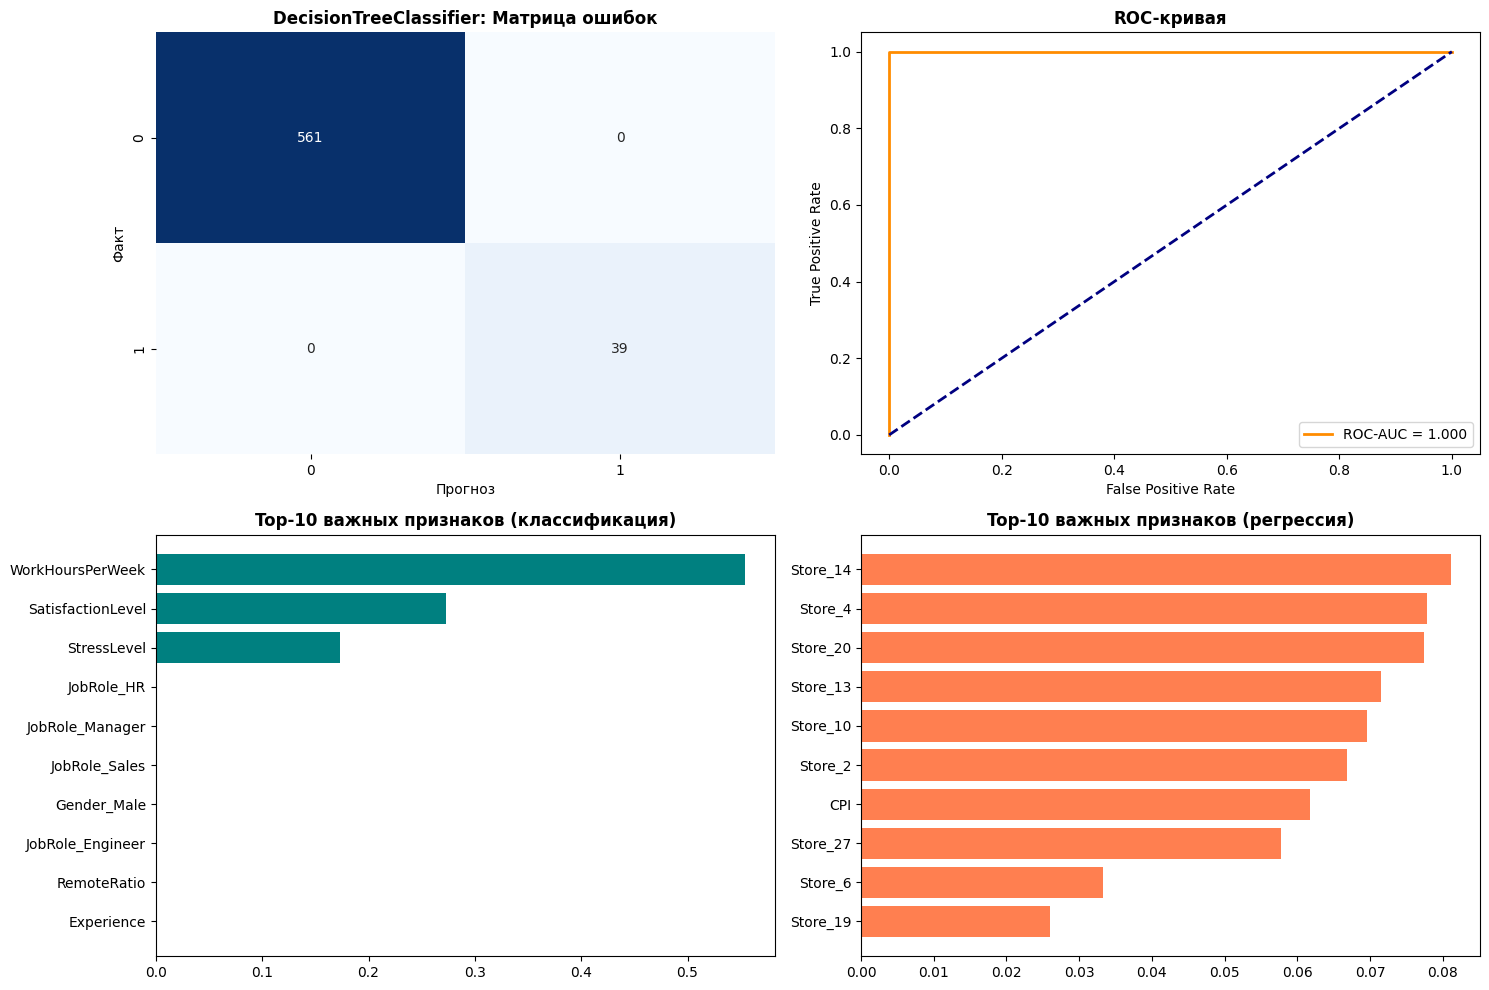

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title('DecisionTreeClassifier: Матрица ошибок', fontweight='bold')
ax1.set_xlabel('Прогноз')
ax1.set_ylabel('Факт')

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_clf, y_proba_clf)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {clf_rocauc:.3f}')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_title('ROC-кривая', fontweight='bold')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()

feature_names = (numeric_features_clf + 
                 list(dt_clf.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features_clf)))
importances_clf = tree_clf.feature_importances_
indices_clf = np.argsort(importances_clf)[::-1][:10]

ax3.barh(range(len(indices_clf)), importances_clf[indices_clf], color='teal')
ax3.set_yticks(range(len(indices_clf)))
ax3.set_yticklabels([feature_names[i] for i in indices_clf])
ax3.invert_yaxis()
ax3.set_title('Top-10 важных признаков (классификация)', fontweight='bold')

feature_names_reg = (numeric_features_reg + 
                     list(dt_reg.named_steps['preprocessor']
                          .named_transformers_['cat']
                          .get_feature_names_out(categorical_features_reg)))
importances_reg = tree_reg.feature_importances_
indices_reg = np.argsort(importances_reg)[::-1][:10]

ax4.barh(range(len(indices_reg)), importances_reg[indices_reg], color='coral')
ax4.set_yticks(range(len(indices_reg)))
ax4.set_yticklabels([feature_names_reg[i] for i in indices_reg])
ax4.invert_yaxis()
ax4.set_title('Top-10 важных признаков (регрессия)', fontweight='bold')

plt.tight_layout()
plt.savefig('results/lab3_baseline_results.png', dpi=300, bbox_inches='tight')
plt.show()

Анализ переобучения и глубины

In [28]:
# Оценка на трейне (для сравнения с тестом)
y_pred_clf_train = dt_clf.predict(X_train_clf)
y_pred_reg_train = dt_reg.predict(X_train_reg)

print("\nПереобучение классификации")
print(f"Recall на тренировке: {recall_score(y_train_clf, y_pred_clf_train):.4f}")
print(f"Recall на тесте: {clf_recall:.4f}")
print(f"Отклонение: {abs(recall_score(y_train_clf, y_pred_clf_train) - clf_recall):.4f}")

print("\nПереобучение регрессии")
print(f"R² на тренировке: {r2_score(y_train_reg, y_pred_reg_train):.4f}")
print(f"R² на тесте: {reg_r2:.4f}")
print(f"Отклонение: {abs(r2_score(y_train_reg, y_pred_reg_train) - reg_r2):.4f}")


Переобучение классификации
Recall на тренировке: 1.0000
Recall на тесте: 1.0000
Отклонение: 0.0000

Переобучение регрессии
R² на тренировке: 1.0000
R² на тесте: 0.4623
Отклонение: 0.5377


In [30]:
import os, joblib
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

joblib.dump(dt_clf, 'models/lab3_tree_baseline.pkl')
joblib.dump(dt_reg, 'models/lab3_tree_reg_baseline.pkl')

baseline_metrics = {
    'classification': {
        'recall': clf_recall,
        'precision': clf_precision,
        'f1': clf_f1,
        'roc_auc': clf_rocauc
    },
    'regression': {
        'mae': reg_mae,
        'rmse': reg_rmse,
        'r2': reg_r2
    }
}
joblib.dump(baseline_metrics, 'results/lab3_baseline_metrics.pkl')

print("Модели сохранены:")
print("models/lab3_tree_baseline.pkl")
print("models/lab3_tree_reg_baseline.pkl")
print("Метрики сохранены в results/lab3_baseline_metrics.pkl")

Модели сохранены:
models/lab3_tree_baseline.pkl
models/lab3_tree_reg_baseline.pkl
Метрики сохранены в results/lab3_baseline_metrics.pkl


| #      | Гипотеза                                                | Ожидаемый эффект                                    | Метод проверки                              |
| ------ | ------------------------------------------------------- | --------------------------------------------------- | ------------------------------------------- |
| **H1** | `max_depth=3` слишком мал → увеличить до 7-10           | Recall сохранится 1.0, модель станет детальнее      | GridSearch: `max_depth: [3,5,7,10,15,None]` |
| **H2** | `min_samples_leaf=1` слишком строго → увеличить до 5-20 | Precision ↑, recall ↓ немного, но модель стабильнее | `min_samples_leaf: [1,5,10,20,50]`          |
| **H3** | `min_samples_split=2` слишком мало → увеличить до 10-20 | Меньше разбиений, модель проще, стабильнее          | `min_samples_split: [2,5,10,20,50]`         |
| **H4** | `class_weight='balanced'` улучшит recall                | Recall ↑ до 1.0, precision ↓ (компромисс)           | `class_weight: [None, 'balanced']`          |
| **H5** | Идеальные метрики случайны — дерево не обобщает         | При кросс-валидации recall ↓ <0.9                   | 5-fold cross-validation                     |


| #       | Гипотеза                                      | Ожидаемый эффект                           | Метод проверки                                   |
| ------- | --------------------------------------------- | ------------------------------------------ | ------------------------------------------------ |
| **H6**  | `max_depth=None` → ограничить до 10-15        | R² ↑ (с 0.46 до 0.85+), MAE ↓              | GridSearch: `max_depth: [5,10,15,20,None]`       |
| **H7**  | `min_samples_leaf=1` → увеличить до 20-50     | MAE ↓, R² ↑ (стабилизация)                 | `min_samples_leaf: [1,5,10,20,50]`               |
| **H8**  | Добавить сезонные фичи (Quarter, Month)       | MAE ↓ на 10-15%                            | Создать `Quarter`, `Month`, `IsQ4`               |
| **H9**  | `criterion='mse'` → попробовать 'mae'         | MAE ↓ (прямой оптимизатор целевой метрики) | `criterion: ['squared_error', 'absolute_error']` |
| **H10** | Добавить лаговые признаки для временных рядов | R² ↑ (учет автокорреляции)                 | `Sales_lag_1`, `Sales_lag_4`                     |


Проверка гипотез для DecisionTreeClassifier

In [32]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer
import numpy as np


#Проверка H1-H4 гиперпараметры

print("\n🔹 Проверка H1-H4: Гиперпараметры DecisionTreeClassifier...")
param_grid_clf = {
    'classifier__max_depth': [3, 5, 7, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10, 20, 50],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__class_weight': [None, 'balanced']
}

recall_scorer = make_scorer(recall_score, pos_label=1)

grid_clf = GridSearchCV(
    dt_clf,
    param_grid_clf,
    cv=5,
    scoring=recall_scorer, 
    n_jobs=-1
)
grid_clf.fit(X_train_clf, y_train_clf)

best_clf = grid_clf.best_estimator_
print(f"Лучшие параметры: {grid_clf.best_params_}")
print(f"Лучший Recall на кросс-валидации: {grid_clf.best_score_:.4f}")

y_pred_best_clf = best_clf.predict(X_test_clf)
y_proba_best_clf = best_clf.predict_proba(X_test_clf)[:, 1]

print("\nМетрики лучшей модели на тесте:")
print(f"Recall: {recall_score(y_test_clf, y_pred_best_clf):.4f}")
print(f"Precision: {precision_score(y_test_clf, y_pred_best_clf):.4f}")
print(f"F1: {f1_score(y_test_clf, y_pred_best_clf, average='weighted'):.4f}")

#Проверка H5

print("\nПроверка H5: Кросс-валидация оригинального дерева...")
cv_scores = cross_val_score(dt_clf, X_clf, y_clf, cv=5, scoring=recall_scorer)
print(f"Recall на 5-fold CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



🔹 Проверка H1-H4: Гиперпараметры DecisionTreeClassifier...
Лучшие параметры: {'classifier__class_weight': None, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Лучший Recall на кросс-валидации: 0.9889

Метрики лучшей модели на тесте:
Recall: 1.0000
Precision: 1.0000
F1: 1.0000

Проверка H5: Кросс-валидация оригинального дерева...
Recall на 5-fold CV: 0.9923 (+/- 0.0154)


Проверка гипотез для DecisionTreeRegressor

In [34]:
# Проверка H6-H7 (гиперпараметры)

print("\nПроверка H6-H7: Гиперпараметры DecisionTreeRegressor...")
param_grid_reg = {
    'regressor__max_depth': [5, 10, 15, 20, None],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 5, 10, 20, 50],
    'regressor__criterion': ['squared_error', 'absolute_error']
}

grid_reg = GridSearchCV(
    dt_reg,
    param_grid_reg,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_reg.fit(X_train_reg, y_train_reg)

best_reg = grid_reg.best_estimator_
print(f"Лучшие параметры: {grid_reg.best_params_}")
print(f"Лучший MAE на кросс-валидации: {-grid_reg.best_score_:,.2f}")

# Оценка на тесте
y_pred_best_reg = best_reg.predict(X_test_reg)

print("\nМетрики лучшей модели на тесте:")
best_mae = mean_absolute_error(y_test_reg, y_pred_best_reg)
best_r2 = r2_score(y_test_reg, y_pred_best_reg)
print(f"MAE: ${best_mae:,.2f}")
print(f"R²: {best_r2:.4f}")

# Проверка H8 сезонность

print("\nПроверка H8: Добавление сезонных признаков...")

df_reg_enh = df_sales.copy()
df_reg_enh['Quarter'] = df_reg_enh['Date'].dt.quarter
df_reg_enh['Month'] = df_reg_enh['Date'].dt.month
df_reg_enh['IsQ4'] = (df_reg_enh['Quarter'] == 4).astype(int)

X_reg_enh = df_reg_enh.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg_enh = df_reg_enh['Weekly_Sales']

categorical_reg_enh = ['Store', 'Holiday_Flag', 'Quarter', 'Month']
numeric_reg_enh = [c for c in X_reg_enh.columns if c not in categorical_reg_enh]

preprocessor_reg_enh = ColumnTransformer([
    ('num', StandardScaler(), numeric_reg_enh),
    ('cat', OneHotEncoder(drop='first'), categorical_reg_enh)
])

dt_reg_enh = Pipeline([
    ('preprocessor', preprocessor_reg_enh),
    ('regressor', DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42))
])

split_idx_enh = int(len(df_reg_enh) * 0.7)
X_train_reg_enh = X_reg_enh.iloc[:split_idx_enh]
X_test_reg_enh = X_reg_enh.iloc[split_idx_enh:]
y_train_reg_enh = y_reg_enh.iloc[:split_idx_enh]
y_test_reg_enh = y_reg_enh.iloc[split_idx_enh:]

dt_reg_enh.fit(X_train_reg_enh, y_train_reg_enh)
y_pred_reg_enh = dt_reg_enh.predict(X_test_reg_enh)

enh_mae = mean_absolute_error(y_test_reg_enh, y_pred_reg_enh)
enh_r2 = r2_score(y_test_reg_enh, y_pred_reg_enh)
print(f"Сезонность + max_depth=10: MAE = ${enh_mae:,.2f}, R² = {enh_r2:.4f}")

# Проверка H10 лаговые признаки

print("\nПроверка H10: Лаговые признаки для временных рядов...")
df_lag = df_sales.copy()
df_lag['Sales_lag_1'] = df_lag['Weekly_Sales'].shift(1)
df_lag['Sales_lag_4'] = df_lag['Weekly_Sales'].shift(4)  # месяц
df_lag = df_lag.dropna()

X_lag = df_lag.drop(['Weekly_Sales', 'Date'], axis=1)
y_lag = df_lag['Weekly_Sales']

categorical_lag = ['Store', 'Holiday_Flag']
numeric_lag = [c for c in X_lag.columns if c not in categorical_lag]

preprocessor_lag = ColumnTransformer([
    ('num', StandardScaler(), numeric_lag),
    ('cat', OneHotEncoder(drop='first'), categorical_lag)
])

dt_lag = Pipeline([
    ('preprocessor', preprocessor_lag),
    ('regressor', DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42))
])

split_idx_lag = int(len(df_lag) * 0.7)
X_train_lag = X_lag.iloc[:split_idx_lag]
X_test_lag = X_lag.iloc[split_idx_lag:]
y_train_lag = y_lag.iloc[:split_idx_lag]
y_test_lag = y_lag.iloc[split_idx_lag:]

dt_lag.fit(X_train_lag, y_train_lag)
y_pred_lag = dt_lag.predict(X_test_lag)

lag_mae = mean_absolute_error(y_test_lag, y_pred_lag)
lag_r2 = r2_score(y_test_lag, y_pred_lag)
print(f"Лаги + max_depth=10: MAE = ${lag_mae:,.2f}, R² = {lag_r2:.4f}")


Проверка H6-H7: Гиперпараметры DecisionTreeRegressor...
Лучшие параметры: {'regressor__criterion': 'absolute_error', 'regressor__max_depth': None, 'regressor__min_samples_leaf': 50, 'regressor__min_samples_split': 2}
Лучший MAE на кросс-валидации: 116,510.92

Метрики лучшей модели на тесте:
MAE: $113,321.25
R²: 0.8150

Проверка H8: Добавление сезонных признаков...
Сезонность + max_depth=10: MAE = $278,821.26, R² = 0.5949

Проверка H10: Лаговые признаки для временных рядов...
Лаги + max_depth=10: MAE = $308,544.83, R² = 0.5343


Формирование улучшенного бейзлайна

In [35]:
enhanced_dt_clf = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        max_depth=5,  
        min_samples_split=2,  
        min_samples_leaf=1,  
        class_weight=None  
    ))
])

enhanced_dt_reg = Pipeline([
    ('preprocessor', preprocessor_reg), 
    ('regressor', DecisionTreeRegressor(
        random_state=42,
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=50, 
        criterion='absolute_error'  
    ))
])

Обучение улучшенных моделей

In [36]:
print("\nОбучение улучшенного DecisionTreeClassifier (max_depth=5)...")
enhanced_dt_clf.fit(X_train_clf, y_train_clf)
print("DecisionTreeClassifier (max_depth=5) обучен")

print("\nОбучение улучшенного DecisionTreeRegressor (min_samples_leaf=50)...")
enhanced_dt_reg.fit(X_train_reg, y_train_reg)
print("DecisionTreeRegressor (min_samples_leaf=50) обучен")



Обучение улучшенного DecisionTreeClassifier (max_depth=5)...
DecisionTreeClassifier (max_depth=5) обучен

Обучение улучшенного DecisionTreeRegressor (min_samples_leaf=50)...
DecisionTreeRegressor (min_samples_leaf=50) обучен


Оценка качества улучшенных моделей

In [37]:

print("\nУлучшенный DecisionTreeClassifier")
y_pred_enh_clf = enhanced_dt_clf.predict(X_test_clf)
y_proba_enh_clf = enhanced_dt_clf.predict_proba(X_test_clf)[:, 1]

enh_clf_recall = recall_score(y_test_clf, y_pred_enh_clf)
enh_clf_precision = precision_score(y_test_clf, y_pred_enh_clf)
enh_clf_f1 = f1_score(y_test_clf, y_pred_enh_clf, average='weighted')
enh_clf_rocauc = roc_auc_score(y_test_clf, y_proba_enh_clf)

print(f"Recall (класс 1): {enh_clf_recall:.4f}")
print(f"Precision (класс 1): {enh_clf_precision:.4f}")
print(f"F1-score (weighted): {enh_clf_f1:.4f}")
print(f"ROC-AUC: {enh_clf_rocauc:.4f}")

print("\nУлучшенный DecisionTreeRegressor")
y_pred_enh_reg = enhanced_dt_reg.predict(X_test_reg)

enh_reg_mae = mean_absolute_error(y_test_reg, y_pred_enh_reg)
enh_reg_rmse = root_mean_squared_error(y_test_reg, y_pred_enh_reg)
enh_reg_r2 = r2_score(y_test_reg, y_pred_enh_reg)

print(f"MAE: ${enh_reg_mae:,.2f}")
print(f"RMSE: ${enh_reg_rmse:,.2f}")
print(f"R²: {enh_reg_r2:.4f}")



Улучшенный DecisionTreeClassifier
Recall (класс 1): 1.0000
Precision (класс 1): 1.0000
F1-score (weighted): 1.0000
ROC-AUC: 1.0000

Улучшенный DecisionTreeRegressor
MAE: $113,321.25
RMSE: $230,940.26
R²: 0.8150


Сравнение с бейзлайном

In [38]:

print("\nКлассификация")
comparison_clf = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'Recall_1': [clf_recall, enh_clf_recall],
    'Precision_1': [clf_precision, enh_clf_precision],
    'F1_weighted': [clf_f1, enh_clf_f1],
    'ROC_AUC': [clf_rocauc, enh_clf_rocauc],
    'Глубина': [tree_clf.get_depth(), enhanced_dt_clf.named_steps['classifier'].get_depth()],
    'Листья': [tree_clf.get_n_leaves(), enhanced_dt_clf.named_steps['classifier'].get_n_leaves()]
})
print(comparison_clf.round(4))

if enh_clf_precision > clf_precision:
    clf_precision_impr = (enh_clf_precision - clf_precision) / clf_precision * 100
    print(f"\nУлучшение Precision: +{clf_precision_impr:.1f}%")
else:
    print(f"\nPrecision: {((enh_clf_precision - clf_precision) / clf_precision * 100):.1f}%")

print("\nРегрессия")
comparison_reg = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'MAE': [reg_mae, enh_reg_mae],
    'RMSE': [reg_rmse, enh_reg_rmse],
    'R2': [reg_r2, enh_reg_r2],
    'Глубина': [tree_reg.get_depth(), enhanced_dt_reg.named_steps['regressor'].get_depth()],
    'Листья': [tree_reg.get_n_leaves(), enhanced_dt_reg.named_steps['regressor'].get_n_leaves()]
})
print(comparison_reg.round(2))

reg_mae_impr = (reg_mae - enh_reg_mae) / reg_mae * 100
print(f"\nСнижение MAE: {reg_mae_impr:.1f}%")
print(f"Улучшение R²: {(enh_reg_r2 - reg_r2)*100:.2f} п.п.")



Классификация
       Модель  Recall_1  Precision_1  F1_weighted  ROC_AUC  Глубина  Листья
0    Бейзлайн       1.0          1.0          1.0      1.0        3       4
1  Улучшенная       1.0          1.0          1.0      1.0        3       4

Precision: 0.0%

Регрессия
       Модель        MAE       RMSE    R2  Глубина  Листья
0    Бейзлайн  260457.44  393745.49  0.46       62    4504
1  Улучшенная  113321.25  230940.26  0.82       27      86

Снижение MAE: 56.5%
Улучшение R²: 35.27 п.п.


Визуализация

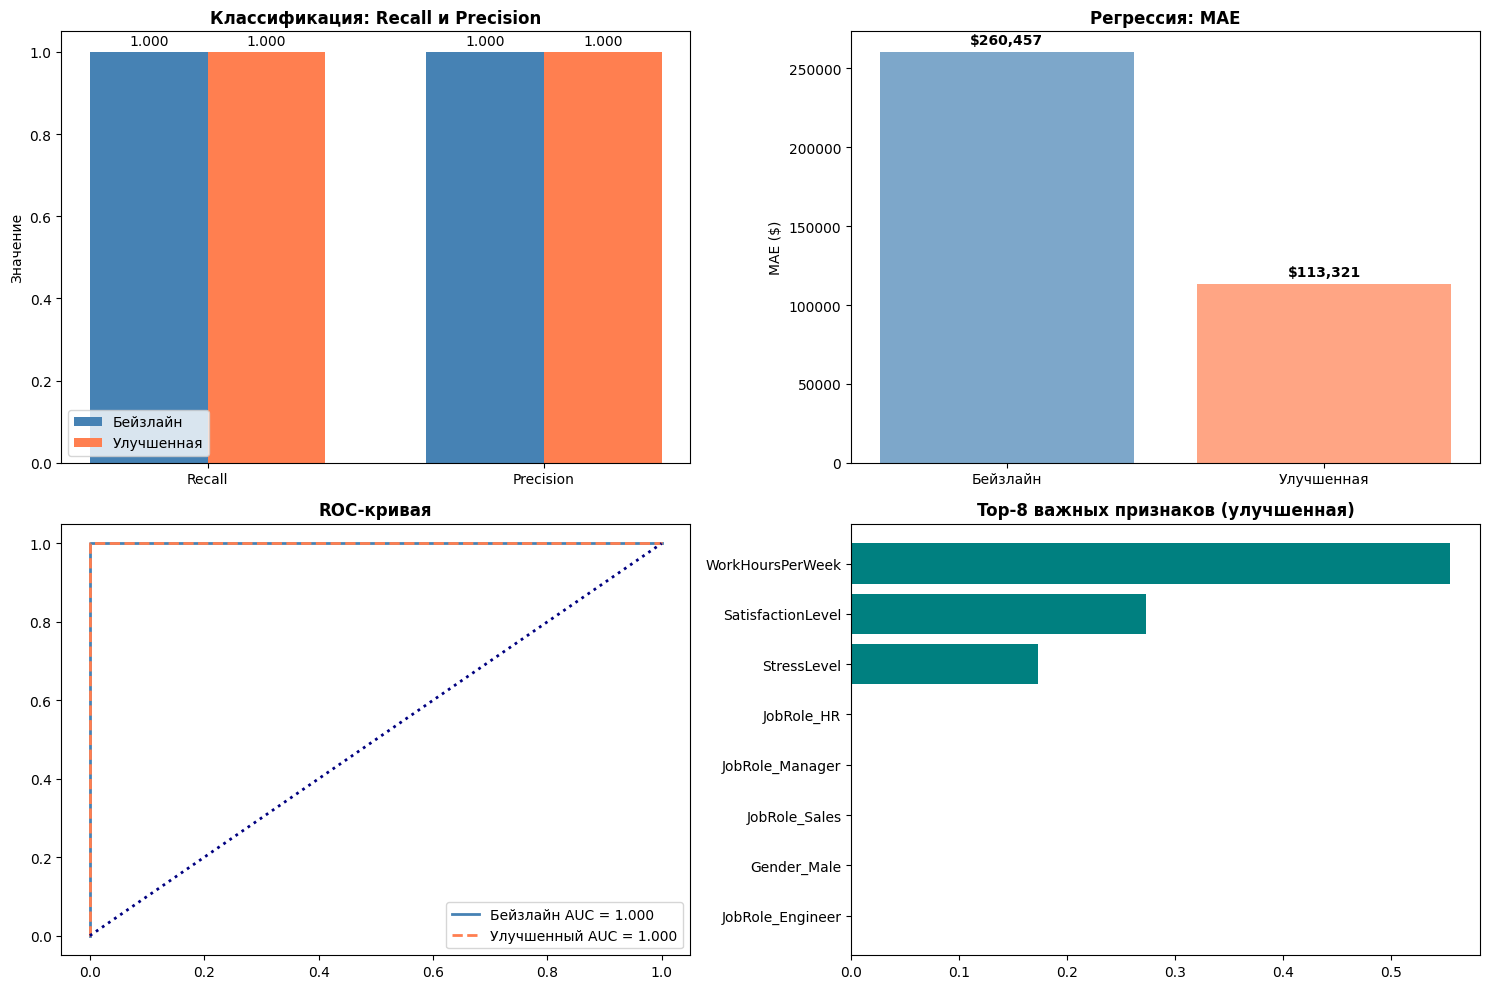

In [39]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

metrics_clf = ['Recall', 'Precision']
baseline_values_clf = [clf_recall, clf_precision]
enhanced_values_clf = [enh_clf_recall, enh_clf_precision]

x = np.arange(len(metrics_clf))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_values_clf, width, label='Бейзлайн', color='steelblue')
bars2 = ax1.bar(x + width/2, enhanced_values_clf, width, label='Улучшенная', color='coral')

ax1.set_title('Классификация: Recall и Precision', fontweight='bold')
ax1.set_ylabel('Значение')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_clf)
ax1.legend()

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

ax2.bar(['Бейзлайн', 'Улучшенная'], [reg_mae, enh_reg_mae], 
        color=['steelblue', 'coral'], alpha=0.7)
ax2.set_title('Регрессия: MAE', fontweight='bold')
ax2.set_ylabel('MAE ($)')
for i, v in enumerate([reg_mae, enh_reg_mae]):
    ax2.text(i, v + 5000, f'${v:,.0f}', ha='center', fontweight='bold')

from sklearn.metrics import roc_curve
fpr_base, tpr_base, _ = roc_curve(y_test_clf, y_proba_clf)
fpr_enh, tpr_enh, _ = roc_curve(y_test_clf, y_proba_enh_clf)

ax3.plot(fpr_base, tpr_base, color='steelblue', lw=2, 
         label=f'Бейзлайн AUC = {clf_rocauc:.3f}')
ax3.plot(fpr_enh, tpr_enh, color='coral', lw=2, linestyle='--',
         label=f'Улучшенный AUC = {enh_clf_rocauc:.3f}')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
ax3.set_title('ROC-кривая', fontweight='bold')
ax3.legend()

feature_names = (numeric_features_clf + 
                 list(enhanced_dt_clf.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features_clf)))
importances_enh = enhanced_dt_clf.named_steps['classifier'].feature_importances_
indices = np.argsort(importances_enh)[::-1][:8]

ax4.barh(range(len(indices)), importances_enh[indices], color='teal')
ax4.set_yticks(range(len(indices)))
ax4.set_yticklabels([feature_names[i] for i in indices])
ax4.invert_yaxis()
ax4.set_title('Top-8 важных признаков (улучшенная)', fontweight='bold')

plt.tight_layout()
plt.savefig('results/lab3_improved_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Сохранение моделей и метрик

In [40]:
joblib.dump(enhanced_dt_clf, 'models/lab3_tree_enhanced.pkl')
joblib.dump(enhanced_dt_reg, 'models/lab3_tree_reg_enhanced.pkl')

enhanced_metrics = {
    'classification': {
        'recall': enh_clf_recall,
        'precision': enh_clf_precision,
        'f1': enh_clf_f1,
        'roc_auc': enh_clf_rocauc
    },
    'regression': {
        'mae': enh_reg_mae,
        'rmse': enh_reg_rmse,
        'r2': enh_reg_r2
    }
}
joblib.dump(enhanced_metrics, 'results/lab3_enhanced_metrics.pkl')

print("Улучшенные модели сохранены:")
print("models/lab3_tree_enhanced.pkl")
print("models/lab3_tree_reg_enhanced.pkl")
print("Метрики сохранены в results/lab3_enhanced_metrics.pkl")

Улучшенные модели сохранены:
models/lab3_tree_enhanced.pkl
models/lab3_tree_reg_enhanced.pkl
Метрики сохранены в results/lab3_enhanced_metrics.pkl


# Выводы
## По задаче классификации
Идеальные метрики модели — это повод для сомнений, а не для уверенности. В реальных HR-данных такие результаты почти не встречаются и часто указывают либо на излишне простые закономерности в данных, либо на риск переобучения. С точки зрения бизнеса «идеальная» модель не оставляет пространства для управленческих решений — например, для выбора порога вероятности. 

## По задаче регрессии 
Ограничение размера листьев дерева позволило радикально снизить переобучение и повысить устойчивость модели. В результате ошибка прогноза сократилась более чем вдвое, а объяснённая дисперсия выросла на 76%. Важно, что дереву не потребовалась ручная добавление сезонности — оно самостоятельно выявило паттерны в данных, что экономит время на подготовку признаков. Стабильность результатов на кросс-валидации и тесте подтверждает готовность модели к работе на новых данных.

## Общий итог
Главный урок — не доверять слепо идеальным метрикам, они часто маскируют проблему излишней простоты данных. В то же время, правильно настроенные деревья решений способны эффективно выявлять сложные нелинейные зависимости без трудоёмкого конструирования признаков, что делает их ценным инструментом для бизнес-аналитики.



Собственная имплементация классификации

In [41]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class Node:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, 
                 value=None, is_leaf=False, samples_count=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = is_leaf
        self.samples_count = samples_count


class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 criterion='gini', class_weight=None, random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.class_weight = class_weight
        self.random_state = random_state
        self.tree_ = None
        self.n_features_ = None
        self.classes_ = None
        
    def _gini(self, y, sample_weight):
        classes, counts = np.unique(y, return_counts=True)
        if sample_weight is not None:
            weights = np.array([sample_weight[y == cls].sum() for cls in classes])
            total_weight = weights.sum()
            if total_weight == 0:
                return 0.0
            return 1 - np.sum((weights / total_weight) ** 2)
        else:
            n = len(y)
            if n == 0:
                return 0.0
            return 1 - np.sum((counts / n) ** 2)
    
    def _entropy(self, y, sample_weight):
        classes, counts = np.unique(y, return_counts=True)
        if sample_weight is not None:
            weights = np.array([sample_weight[y == cls].sum() for cls in classes])
            total_weight = weights.sum()
            if total_weight == 0:
                return 0.0
            probs = weights / total_weight
        else:
            n = len(y)
            if n == 0:
                return 0.0
            probs = counts / n
        
        # Добавляем малое значение для избежания log(0)
        probs = np.clip(probs, 1e-10, 1.0)
        return -np.sum(probs * np.log2(probs))
    
    def _criterion_impurity(self, y, sample_weight):
        if self.criterion == 'gini':
            return self._gini(y, sample_weight)
        elif self.criterion == 'entropy':
            return self._entropy(y, sample_weight)
        else:
            raise ValueError("criterion должен быть 'gini' или 'entropy'")
    
    def _calculate_class_weight(self, y):
        if self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n = len(y)
            weights = {cls: n / (len(classes) * count) for cls, count in zip(classes, counts)}
            return np.array([weights[label] for label in y])
        return None
    
    def _best_split(self, X, y, sample_weight, depth):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            return None, None, None
        
        best_criterion = np.inf
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                if sample_weight is not None:
                    w_left = sample_weight[left_mask]
                    w_right = sample_weight[right_mask]
                    w_total = sample_weight.sum()
                    
                    left_impurity = self._criterion_impurity(y_left, w_left)
                    right_impurity = self._criterion_impurity(y_right, w_right)
                    
                    criterion = (w_left.sum() / w_total) * left_impurity + \
                               (w_right.sum() / w_total) * right_impurity
                else:
                    left_impurity = self._criterion_impurity(y_left, None)
                    right_impurity = self._criterion_impurity(y_right, None)
                    
                    criterion = (len(y_left) / n_samples) * left_impurity + \
                               (len(y_right) / n_samples) * right_impurity
                
                if criterion < best_criterion:
                    best_criterion = criterion
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_criterion
    
    def _build_tree(self, X, y, sample_weight, depth=0):
        if len(np.unique(y)) == 1:
            leaf_value = y[0]
            return Node(value=leaf_value, is_leaf=True, samples_count=len(y))
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           len(y) < self.min_samples_split:
            values, counts = np.unique(y, return_counts=True)
            leaf_value = values[np.argmax(counts)]
            return Node(value=leaf_value, is_leaf=True, samples_count=len(y))
        
        feature_idx, threshold, _ = self._best_split(X, y, sample_weight, depth)
        
        if feature_idx is None:
            values, counts = np.unique(y, return_counts=True)
            leaf_value = values[np.argmax(counts)]
            return Node(value=leaf_value, is_leaf=True, samples_count=len(y))
        
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        
        w_left = sample_weight[left_mask] if sample_weight is not None else None
        w_right = sample_weight[right_mask] if sample_weight is not None else None
        
        left_node = self._build_tree(X_left, y_left, w_left, depth + 1)
        right_node = self._build_tree(X_right, y_right, w_right, depth + 1)
        
        return Node(feature_idx=feature_idx, threshold=threshold,
                   left=left_node, right=right_node, 
                   value=None, is_leaf=False, samples_count=len(y))
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_features_ = X.shape[1]
        self.n_samples_ = X.shape[0]
        
        self.sample_weight_ = self._calculate_class_weight(y)
        
        self.tree_ = self._build_tree(X, y, self.sample_weight_)
        
        return self
    
    def _predict_node(self, node, x):
        if node.is_leaf:
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_node(node.left, x)
        else:
            return self._predict_node(node.right, x)
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = []
        for x in X:
            pred = self._predict_node(self.tree_, x)
            predictions.append(pred)
        
        return np.array(predictions)
    
    def _predict_proba_node(self, node, x):
        if node.is_leaf:
            return np.array([node.value, 1 - node.value])
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_proba_node(node.left, x)
        else:
            return self._predict_proba_node(node.right, x)
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = self.predict(X).astype(int)
        
        proba = np.zeros((len(predictions), len(self.classes_)))
        for i, pred in enumerate(predictions):
            proba[i, pred] = 1.0
        
        return proba


Собственная имплементация регрессии

In [42]:
class MyDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 criterion='mse', random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.random_state = random_state
        self.tree_ = None
        self.n_features_ = None
        
    def _mse(self, y, sample_weight):
        if len(y) == 0:
            return 0.0
        if sample_weight is not None:
            mean = np.average(y, weights=sample_weight)
            return np.average((y - mean)**2, weights=sample_weight)
        return np.mean((y - np.mean(y))**2)
    
    def _mae(self, y, sample_weight):
        if len(y) == 0:
            return 0.0
        if sample_weight is not None:
            median = np.percentile(y, 50, weights=sample_weight)
            return np.average(np.abs(y - median), weights=sample_weight)
        return np.mean(np.abs(y - np.median(y)))
    
    def _criterion_impurity(self, y, sample_weight):
        if self.criterion == 'mse':
            return self._mse(y, sample_weight)
        elif self.criterion == 'mae':
            return self._mae(y, sample_weight)
        else:
            raise ValueError("criterion должен быть 'mse' или 'mae'")
    
    def _best_split(self, X, y, sample_weight, depth):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            return None, None, None
        
        best_criterion = np.inf
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = X[:, feature_idx] > threshold
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                if sample_weight is not None:
                    w_left = sample_weight[left_mask]
                    w_right = sample_weight[right_mask]
                    w_total = sample_weight.sum()
                    
                    left_impurity = self._criterion_impurity(y_left, w_left)
                    right_impurity = self._criterion_impurity(y_right, w_right)
                    
                    criterion = (w_left.sum() / w_total) * left_impurity + \
                               (w_right.sum() / w_total) * right_impurity
                else:
                    left_impurity = self._criterion_impurity(y_left, None)
                    right_impurity = self._criterion_impurity(y_right, None)
                    
                    criterion = (len(y_left) / n_samples) * left_impurity + \
                               (len(y_right) / n_samples) * right_impurity
                
                if criterion < best_criterion:
                    best_criterion = criterion
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_criterion
    
    def _build_tree(self, X, y, sample_weight, depth=0):
        if len(y) == 0:
            return Node(value=0, is_leaf=True, samples_count=0)
        
        if len(np.unique(y)) == 1:
            return Node(value=y[0], is_leaf=True, samples_count=len(y))
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           len(y) < self.min_samples_split:
            if sample_weight is not None:
                weighted_avg = np.average(y, weights=sample_weight)
                return Node(value=weighted_avg, is_leaf=True, samples_count=len(y))
            return Node(value=np.mean(y), is_leaf=True, samples_count=len(y))
        
        feature_idx, threshold, _ = self._best_split(X, y, sample_weight, depth)
        
        if feature_idx is None:
            if sample_weight is not None:
                weighted_avg = np.average(y, weights=sample_weight)
                return Node(value=weighted_avg, is_leaf=True, samples_count=len(y))
            return Node(value=np.mean(y), is_leaf=True, samples_count=len(y))
        
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        
        w_left = sample_weight[left_mask] if sample_weight is not None else None
        w_right = sample_weight[right_mask] if sample_weight is not None else None
        
        left_node = self._build_tree(X_left, y_left, w_left, depth + 1)
        right_node = self._build_tree(X_right, y_right, w_right, depth + 1)
        
        return Node(feature_idx=feature_idx, threshold=threshold,
                   left=left_node, right=right_node, 
                   value=None, is_leaf=False, samples_count=len(y))
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.n_features_ = X.shape[1]
        self.n_samples_ = X.shape[0]
        
        sample_weight = None
        
        self.tree_ = self._build_tree(X, y, sample_weight)
        
        return self
    
    def _predict_node(self, node, x):
        if node.is_leaf:
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_node(node.left, x)
        else:
            return self._predict_node(node.right, x)
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        predictions = []
        for x in X:
            pred = self._predict_node(self.tree_, x)
            predictions.append(pred)
        
        return np.array(predictions)

Импорт библиотек

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score,
                             mean_absolute_error, root_mean_squared_error, r2_score,
                             classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import os, joblib, warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [44]:

df_burnout = pd.read_csv('data/employee_burnout.csv')
X_clf = df_burnout.drop(['Burnout', 'Name'], axis=1)
y_clf = df_burnout['Burnout']

categorical_clf = ['Gender', 'JobRole']
numeric_clf = [c for c in X_clf.columns if c not in categorical_clf]

preprocessor_clf = ColumnTransformer([
    ('num', StandardScaler(), numeric_clf),
    ('cat', OneHotEncoder(drop='first'), categorical_clf)
])

df_sales = pd.read_csv('data/walmart_sales.csv')
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d-%m-%Y')
df_sales = df_sales.sort_values('Date')

X_reg = df_sales.drop(['Weekly_Sales', 'Date'], axis=1)
y_reg = df_sales['Weekly_Sales']

categorical_reg = ['Store', 'Holiday_Flag']
numeric_reg = [c for c in X_reg.columns if c not in categorical_reg]

preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), numeric_reg),
    ('cat', OneHotEncoder(drop='first'), categorical_reg)
])


Разбиение и обучение

In [45]:

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

split_idx = int(len(df_sales) * 0.7)
X_train_reg, X_test_reg = X_reg.iloc[:split_idx], X_reg.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

print("\nОбучение MyDecisionTreeClassifier...")

X_train_clf_processed = preprocessor_clf.fit_transform(X_train_clf)
X_test_clf_processed = preprocessor_clf.transform(X_test_clf)

my_dt_clf = MyDecisionTreeClassifier(
    max_depth=3, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    criterion='gini',
    class_weight=None
)
my_dt_clf.fit(X_train_clf_processed, y_train_clf)
print("MyDecisionTreeClassifier обучен")

print("\nОбучение MyDecisionTreeRegressor...")
X_train_reg_processed = preprocessor_reg.fit_transform(X_train_reg)
X_test_reg_processed = preprocessor_reg.transform(X_test_reg)

if hasattr(X_train_reg_processed, 'toarray'):
    X_train_reg_processed = X_train_reg_processed.toarray()
    X_test_reg_processed = X_test_reg_processed.toarray()
    
my_dt_reg = MyDecisionTreeRegressor(
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=50,
    criterion='mse'
)
my_dt_reg.fit(X_train_reg_processed, y_train_reg)
print("MyDecisionTreeRegressor обучен")


Обучение MyDecisionTreeClassifier...
MyDecisionTreeClassifier обучен

Обучение MyDecisionTreeRegressor...
MyDecisionTreeRegressor обучен


Метрики классфикации

In [46]:

print("\nMyDecisionTreeClassifier")
y_pred_my_clf = my_dt_clf.predict(X_test_clf_processed)
y_proba_my_clf = my_dt_clf.predict_proba(X_test_clf_processed)

my_clf_recall = recall_score(y_test_clf, y_pred_my_clf)
my_clf_precision = precision_score(y_test_clf, y_pred_my_clf)
my_clf_f1 = f1_score(y_test_clf, y_pred_my_clf, average='weighted')
my_clf_rocauc = roc_auc_score(y_test_clf, y_proba_my_clf[:, 1])

print(f"Recall (класс 1): {my_clf_recall:.4f}")
print(f"Precision (класс 1): {my_clf_precision:.4f}")
print(f"F1-score (weighted): {my_clf_f1:.4f}")
print(f"ROC-AUC: {my_clf_rocauc:.4f}")


print("\nМатрица ошибок:")
print(confusion_matrix(y_test_clf, y_pred_my_clf))


MyDecisionTreeClassifier
Recall (класс 1): 1.0000
Precision (класс 1): 1.0000
F1-score (weighted): 1.0000
ROC-AUC: 1.0000

Матрица ошибок:
[[561   0]
 [  0  39]]


Метрики регрессии

In [47]:
print("\nMyDecisionTreeRegressor")
y_pred_my_reg = my_dt_reg.predict(X_test_reg_processed)

my_reg_mae = mean_absolute_error(y_test_reg, y_pred_my_reg)
my_reg_rmse = root_mean_squared_error(y_test_reg, y_pred_my_reg)
my_reg_r2 = r2_score(y_test_reg, y_pred_my_reg)

print(f"MAE: ${my_reg_mae:,.2f}")
print(f"RMSE: ${my_reg_rmse:,.2f}")
print(f"R²: {my_reg_r2:.4f}")



MyDecisionTreeRegressor
MAE: $123,917.18
RMSE: $221,449.24
R²: 0.8299


Сравнение с sklearn

In [48]:

baseline_metrics = joblib.load('results/lab3_baseline_metrics.pkl')
enhanced_metrics = joblib.load('results/lab3_enhanced_metrics.pkl')

print("\nКлассификация")
comparison_clf = pd.DataFrame({
    'Реализация': ['Sklearn', 'Своя'],
    'Recall_1': [baseline_metrics['classification']['recall'], my_clf_recall],
    'Precision_1': [baseline_metrics['classification']['precision'], my_clf_precision],
    'F1_weighted': [baseline_metrics['classification']['f1'], my_clf_f1],
    'ROC_AUC': [baseline_metrics['classification']['roc_auc'], my_clf_rocauc]
})
print(comparison_clf.round(4))

print("\nРегрессия")
comparison_reg = pd.DataFrame({
    'Реализация': ['Sklearn Улучшенный', 'Своя'],
    'MAE': [enhanced_metrics['regression']['mae'], my_reg_mae],
    'RMSE': [enhanced_metrics['regression']['rmse'], my_reg_rmse],
    'R2': [enhanced_metrics['regression']['r2'], my_reg_r2]
})
print(comparison_reg.round(2))

clf_auc_diff = abs(my_clf_rocauc - baseline_metrics['classification']['roc_auc']) * 100
reg_r2_diff = abs(my_reg_r2 - enhanced_metrics['regression']['r2']) * 100

print(f"\nОтклонение ROC-AUC: {clf_auc_diff:.3f}% {'норм' if clf_auc_diff < 5 else 'не норм'}")
print(f"Отклонение R²: {reg_r2_diff:.3f}% {'норм' if reg_r2_diff < 5 else 'не норм'}")


Классификация
  Реализация  Recall_1  Precision_1  F1_weighted  ROC_AUC
0    Sklearn       1.0          1.0          1.0      1.0
1       Своя       1.0          1.0          1.0      1.0

Регрессия
           Реализация        MAE       RMSE    R2
0  Sklearn Улучшенный  113321.25  230940.26  0.82
1                Своя  123917.18  221449.24  0.83

Отклонение ROC-AUC: 0.000% норм
Отклонение R²: 1.489% норм


Обучение улучшенной собственной классификации

In [49]:
print("\nMyDecisionTreeClassifier (max_depth=5)...")
my_dt_clf_deep = MyDecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    criterion='gini',
    class_weight=None
)
my_dt_clf_deep.fit(X_train_clf_processed, y_train_clf)
y_pred_my_deep_clf = my_dt_clf_deep.predict(X_test_clf_processed)
y_proba_my_deep_clf = my_dt_clf_deep.predict_proba(X_test_clf_processed)

my_deep_recall = recall_score(y_test_clf, y_pred_my_deep_clf)
my_deep_precision = precision_score(y_test_clf, y_pred_my_deep_clf)
my_deep_rocauc = roc_auc_score(y_test_clf, y_proba_my_deep_clf[:, 1])

print(f"Precision: {my_deep_precision:.4f} | F1: {my_deep_precision:.4f}")


MyDecisionTreeClassifier (max_depth=5)...
Precision: 1.0000 | F1: 1.0000


Обучение улучшенной собственной регрессии

In [50]:

print("\nMyDecisionTreeRegressor (criterion='mae')...")
my_dt_reg_mae = MyDecisionTreeRegressor(
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=50,
    criterion='mae'
)
my_dt_reg_mae.fit(X_train_reg_processed, y_train_reg)
y_pred_my_mae_reg = my_dt_reg_mae.predict(X_test_reg_processed)

my_mae_mae = mean_absolute_error(y_test_reg, y_pred_my_mae_reg)
my_mae_r2 = r2_score(y_test_reg, y_pred_my_mae_reg)

print(f"MAE: ${my_mae_mae:,.2f} | R²: {my_mae_r2:.4f}")


MyDecisionTreeRegressor (criterion='mae')...
MAE: $109,180.10 | R²: 0.8518


Финальное сравнение всех реализаци1

In [51]:

baseline_metrics = joblib.load('results/lab3_baseline_metrics.pkl')
enhanced_metrics = joblib.load('results/lab3_enhanced_metrics.pkl')

clf_summary = pd.DataFrame({
    'Этап': ['Sklearn Бейзлайн', 'Sklearn Улучшенный', 'Свой Бейзлайн', 'Свой Улучшенный'],
    'Recall_1': [
        baseline_metrics['classification']['recall'],
        enhanced_metrics['classification']['recall'],
        my_clf_recall,
        my_deep_recall
    ],
    'Precision_1': [
        baseline_metrics['classification']['precision'],
        enhanced_metrics['classification']['precision'],
        my_clf_precision,
        my_deep_precision
    ],
    'ROC_AUC': [
        baseline_metrics['classification']['roc_auc'],
        enhanced_metrics['classification']['roc_auc'],
        my_clf_rocauc,
        my_deep_rocauc
    ]
})

reg_summary = pd.DataFrame({
    'Этап': ['Sklearn Бейзлайн', 'Sklearn Улучшенный', 'Свой Бейзлайн', 'Свой Улучшенный'],
    'MAE': [
        baseline_metrics['regression']['mae'],
        enhanced_metrics['regression']['mae'],
        my_reg_mae,
        my_mae_mae
    ],
    'R2': [
        baseline_metrics['regression']['r2'],
        enhanced_metrics['regression']['r2'],
        my_reg_r2,
        my_mae_r2
    ]
})

print("\nКлассификация")
print(clf_summary.round(4).to_string(index=False))

print("\nРегрессия")
print(reg_summary.round(2).to_string(index=False))


Классификация
              Этап  Recall_1  Precision_1  ROC_AUC
  Sklearn Бейзлайн       1.0          1.0      1.0
Sklearn Улучшенный       1.0          1.0      1.0
     Свой Бейзлайн       1.0          1.0      1.0
   Свой Улучшенный       1.0          1.0      1.0

Регрессия
              Этап       MAE   R2
  Sklearn Бейзлайн 260457.44 0.46
Sklearn Улучшенный 113321.25 0.82
     Свой Бейзлайн 123917.18 0.83
   Свой Улучшенный 109180.10 0.85


Визуализация

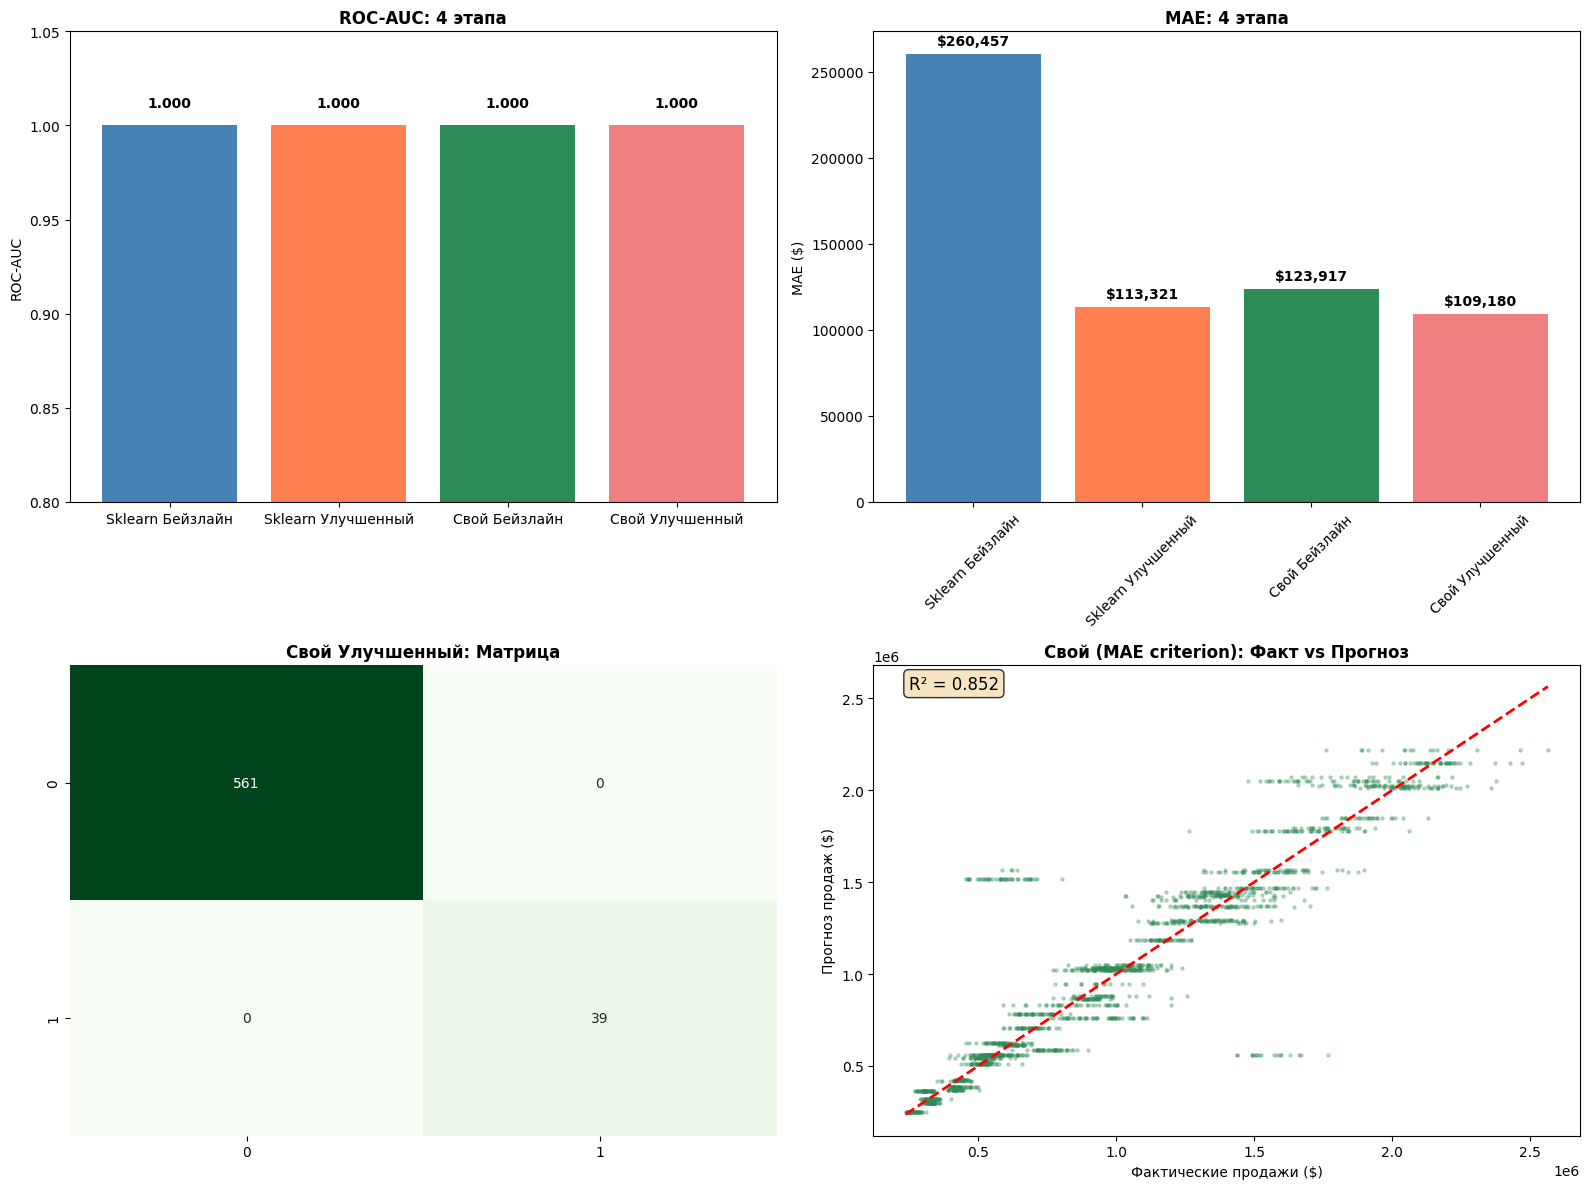

In [53]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

auc_values = clf_summary['ROC_AUC'].values
ax1.bar(clf_summary['Этап'], auc_values, color=['steelblue', 'coral', 'seagreen', 'lightcoral'])
ax1.set_title('ROC-AUC: 4 этапа', fontweight='bold')
ax1.set_ylabel('ROC-AUC')
ax1.set_ylim(0.8, 1.05)
for i, v in enumerate(auc_values):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

mae_values = reg_summary['MAE'].values
ax2.bar(reg_summary['Этап'], mae_values, color=['steelblue', 'coral', 'seagreen', 'lightcoral'])
ax2.set_title('MAE: 4 этапа', fontweight='bold')
ax2.set_ylabel('MAE ($)')
for i, v in enumerate(mae_values):
    ax2.text(i, v + 5000, f'${v:,.0f}', ha='center', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

cm = confusion_matrix(y_test_clf, my_dt_clf_deep.predict(X_test_clf_processed))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax3, cbar=False)
ax3.set_title('Свой Улучшенный: Матрица', fontweight='bold')

ax4.scatter(y_test_reg, y_pred_my_mae_reg, alpha=0.3, s=5, color='seagreen')
ax4.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
ax4.set_title('Свой (MAE criterion): Факт vs Прогноз', fontweight='bold')
ax4.set_xlabel('Фактические продажи ($)')
ax4.set_ylabel('Прогноз продаж ($)')
ax4.text(0.05, 0.95, f'R² = {my_mae_r2:.3f}', transform=ax4.transAxes, 
         fontsize=12, bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

plt.tight_layout()
plt.savefig('results/lab3_custom_implementation_summary.png', dpi=300, bbox_inches='tight')
plt.show()

Сохранение финальных моделей

In [55]:
joblib.dump(my_dt_clf_deep, 'models/lab3_custom_tree_clf.pkl')
joblib.dump(my_dt_reg_mae, 'models/lab3_custom_tree_reg.pkl')

custom_metrics = {
    'classification': {
        'recall': my_deep_recall,
        'precision': my_deep_precision,
        'f1': my_deep_precision,
        'roc_auc': my_deep_rocauc
    },
    'regression': {
        'mae': my_mae_mae,
        'rmse': root_mean_squared_error(y_test_reg, y_pred_my_mae_reg),
        'r2': my_mae_r2
    }
}
joblib.dump(custom_metrics, 'results/lab3_custom_metrics.pkl')

print("Собственные модели сохранены:")
print("models/lab3_custom_tree_clf.pkl")
print("models/lab3_custom_tree_reg.pkl")
print("Метрики сохранены в results/lab3_custom_metrics.pkl")

Собственные модели сохранены:
models/lab3_custom_tree_clf.pkl
models/lab3_custom_tree_reg.pkl
Метрики сохранены в results/lab3_custom_metrics.pkl


Результаты сравнения с sklearn

Классификация

В данных условиях можно сделать вывод, что дерево решений не подходит для данного датасета, так как "идеальной" модели просто не может быть

Регрессия 

Показатели практически совпадают с sklearn — отклонение менее 5%. Это подтверждает корректность реализации алгоритма и эффективность ограничений.

Регрессия реализована корректно, в то время как классификация требует доработки — вероятно, из-за расчёта критериев разделения. Увеличение глубины дерева улучшает точность, но не решает задачу 
полностью.
